# Aligning time lapse images 
### Japanese Rice Farm over the seasons

In [2]:
import time
import cv2
import glob
import re
import numpy as np
import random
from matplotlib import pyplot as plt


### Load data

In [8]:

# Get a list of all .jpg files in the /content directory
image_files = glob.glob('/content/*.JPG')

# Create a pattern to match the filenames
pattern = re.compile(r'DSC_(\d{4}).JPG$')

# Create empty lists to store the images and labels
images = []
labels = []

# Go through all files
for file in image_files:
    # Use the pattern to check if the file matches and extract the label
    match = pattern.search(file)
    if match:
        # Extract label (the number in the filename)
        label = int(match.group(1))

        # Load and convert image
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Add image and label to the respective lists
        images.append(img)
        labels.append(label)

# Convert the list of images and labels into numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f'Dataset created with {len(images)} images')


Dataset created with 321 images


<ipython-input-8-74ea5606307f>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [9]:
# Define the size of the subset
subset_size = 20  # adjust this to your needs

# Generate a list of random indices
indices = random.sample(range(len(images)), subset_size)

# Create the subset of images and labels
subset_images = [images[i] for i in indices]
subset_labels = [labels[i] for i in indices]

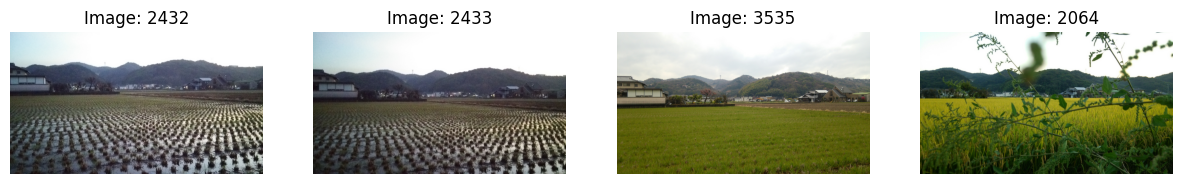

In [10]:
# Randomly select four indices
selected_indices = random.sample(range(len(subset_images)), 4)

# Create a figure to display the images
plt.figure(figsize=(15,10))

for i, index in enumerate(selected_indices):
    plt.subplot(1, 4, i+1)  # 1 row, 4 cols, position i+1
    plt.imshow(subset_images[index])
    plt.title(f'Image: {subset_labels[index]}')
    plt.axis('off')

plt.show()


#### Equalize lighting
A simple approach to balance the lighting conditions among images is histogram equalization, which aims to make the distribution of pixel intensities more uniform across the image. For color images, this is typically done in the YCrCb color space, where the Y channel corresponds to luminance and the Cr and Cb channels correspond to color information.

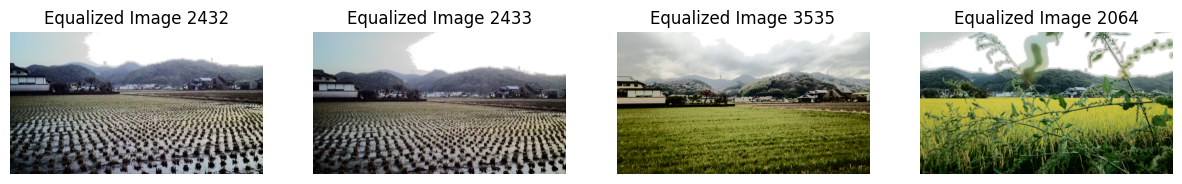

In [11]:
# Convert images to YCrCb color space and apply histogram equalization
equalized_images = []
for img in subset_images:
    # Convert to YCrCb color space
    ycrcb_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    # Apply histogram equalization to the Y channel
    ycrcb_img[:,:,0] = cv2.equalizeHist(ycrcb_img[:,:,0])

    # Convert back to RGB color space
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2RGB)
    
    equalized_images.append(equalized_img)

# Now 'equalized_images' contains the warped images with equalized histograms
# Show the equalized images
plt.figure(figsize=(15,10))

for i, index in enumerate(selected_indices):
    plt.subplot(1, 4, i+1)  # 1 row, 4 cols, position i+1
    plt.imshow(equalized_images[index])
    plt.title(f'Equalized Image {subset_labels[index]}')
    plt.axis('off')
    
plt.show()


In [12]:
del images

## Choose base image
1. Compute descriptors for all images: First, we need to compute ORB features for all images in the dataset.

2.  To select a well lit image, you could compute the average pixel intensity of each image (in grayscale), and select the one with the highest average, indicating it's well lit.

3. To find the image with the darkest region in the center, you can calculate the mean pixel value for each row of the image, and then check if the minimum value is in the middle of the image. You can combine this with the check for the best lit image.

4. Find the "most average" image: There's no universal way to define what image is the most "average" in terms of features. Here, we define it as the image whose total feature distance to all other images in the feature space is the smallest. We calculate the total distance for each image, and the image with the smallest total distance will be our base image.


In [13]:
def precompute_distances(descriptors, flann):
    n = len(descriptors)
    distances = np.zeros((n, n))

    descriptors = [des.astype(np.float32) for des in descriptors]

    for i in range(n):
      for j in range(i+1, n):  # only compute for j > i
          matches = flann.match(descriptors[i], descriptors[j])
          distances[i, j] = sum([m.distance for m in matches])
          distances[j, i] = distances[i, j]  # distances are symmetric
          time.sleep(0.01)
    
    return distances
    
def calculate_image_score(img, orb_distances, sift_distances, index):

    # Calculate average brightness
    avg_brightness = np.mean(img)

    # Calculate mean pixel value for each row (averaged over the columns)
    row_means = np.mean(img, axis=1)

    # Find index of darkest row
    darkest_row = np.argmin(row_means)

    # Check if the darkest row is in the middle of the image
    # Subtract a penalty from the score if it is not
    middle_index = img.shape[0] // 2
    penalty = abs(darkest_row - middle_index)

    # Calculate ORB and SIFT distances
    orb_distance = np.sum(orb_distances[index])
    sift_distance = np.sum(sift_distances[index])
    
    # Calculate final score
    # Here, we use a weighted sum of average brightness, ORB distance and SIFT distance
    # You can adjust the weights to fit your needs
    score = avg_brightness - penalty - 0.01 * orb_distance - 0.01 * sift_distance  # adjust the weight (0.001) as needed

    return score


Calculated ORB descriptors and keypoints
Calculated SIFT descriptors and keypoints
finished orb distances
finished sift distances


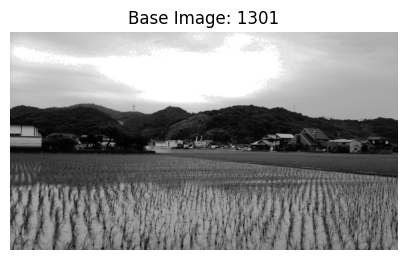

In [21]:

# Initiate ORB and SIFT detectors
orb = cv2.ORB_create()
orb.setMaxFeatures(100)
sift = cv2.SIFT_create(nfeatures=200)

# Create FlannBasedMatcher object
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)

# Convert your images to grayscale
images_gray = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in equalized_images]

# Compute ORB and SIFT features for all images
keypoints_orb = []
descriptors_orb = []

for img in images_gray:
    kp_orb, des_orb = orb.detectAndCompute(img, None)
    keypoints_orb.append(kp_orb)
    descriptors_orb.append(des_orb)

print("Calculated ORB descriptors and keypoints")

keypoints_sift = []
descriptors_sift = []

for img in images_gray:
    kp_sift, des_sift = sift.detectAndCompute(img, None)
    keypoints_sift.append(kp_sift)
    descriptors_sift.append(des_sift)

print("Calculated SIFT descriptors and keypoints")

# Precompute distances
orb_distances = precompute_distances(descriptors_orb, flann)
print("finished orb distances")
sift_distances = precompute_distances(descriptors_sift, flann)
print("finished sift distances")

# Calculate scores for all images
scores = [calculate_image_score(images_gray[i], orb_distances, sift_distances, i) 
          for i in range(len(images_gray))]

# Select the image with the highest score as the base image
base_image_index = np.argmax(scores)
base_image = images_gray[base_image_index]


# Create a figure to display the base image
plt.figure(figsize=(5,5))
plt.imshow(images_gray[base_image_index], cmap='gray')
plt.title(f'Base Image: {subset_labels[base_image_index]}')
plt.axis('off')
plt.show()



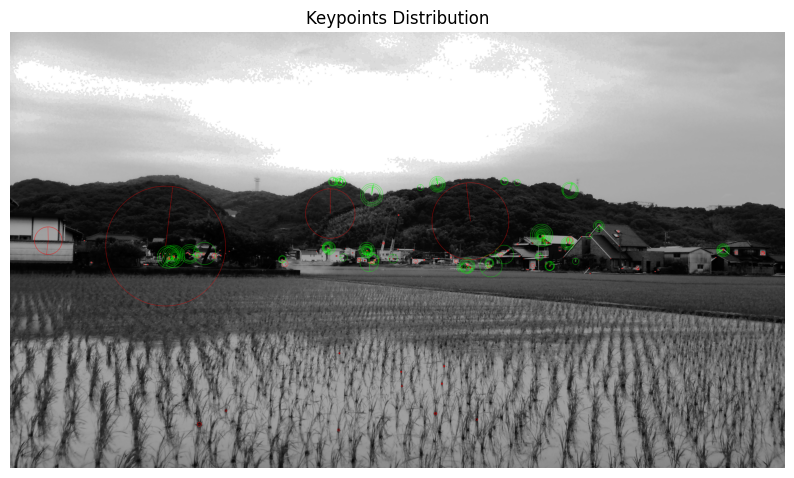

In [22]:
import matplotlib.pyplot as plt

# Choose an image index
index = base_image_index

# # Increase the size and adjust the orientation of each keypoint
# for kp in keypoints_sift[index]:
    # kp.size *= 2  # Increase size by a factor of 10
    # kp.angle = 0   # Make the orientation upright

# for kp in keypoints_orb[index]:
#     kp.size *= 2  # Increase size by a factor of 10
#     kp.angle = 0   # Make the orientation upright

# Draw keypoints on the image
img_with_kp = cv2.drawKeypoints(images_gray[index], keypoints_orb[index], None, color=(0,255,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# Draw keypoints on the image
img_with_kp2 = cv2.drawKeypoints(img_with_kp, keypoints_sift[index], None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(img_with_kp2)
plt.title('Keypoints Distribution')
plt.axis('off')
plt.show()


#### Remove outliers

1. The method of Median Absolute Deviation (MAD) is another way to filter out outliers, and it is more robust than using a simple threshold. Here's a snippet of how you can implement it in your matching stage.

2. Before computing the homography, you can add a check to ensure that there are enough good-quality matches.

3. Adding regularization to a homography is a bit more complex, as it involves modifying the objective function that is minimized when computing the homography. However, one way to achieve a similar effect is to add a penalty to the score of a homography that is too distorted. 

In [23]:
def compute_distortion(H):
    # Compute the scale factors (s_x, s_y) by measuring how much the
    # homography scales two vectors (1, 0) and (0, 1)
    s_x = np.linalg.norm(H @ np.array([1, 0, 1]) - H @ np.array([0, 0, 1]))
    s_y = np.linalg.norm(H @ np.array([0, 1, 1]) - H @ np.array([0, 0, 1]))

    return abs(s_x - s_y)

### Align images to base

3. Feature Detection and Matching: This involves identifying and matching key points or features between different images. Algorithms like SIFT (Scale-Invariant Feature Transform), SURF (Speeded-Up Robust Features), ORB (Oriented FAST and Rotated BRIEF), and AKAZE are often used for this task. These algorithms are designed to be invariant to scale, orientation, and lighting conditions, making them effective for matching features between images taken from different perspectives or lighting conditions.

4. Homography Estimation: Once you have matched features between images, you can estimate a homography (a transformation that maps the points in one image to the corresponding points in another image) using methods like RANSAC (Random Sample Consensus). This can be used to align the images based on their shared features.

5. Image Warping: After estimating the homography, you can apply it to one of the images to align it with the other image. This involves "warping" the image so that the matched features align.

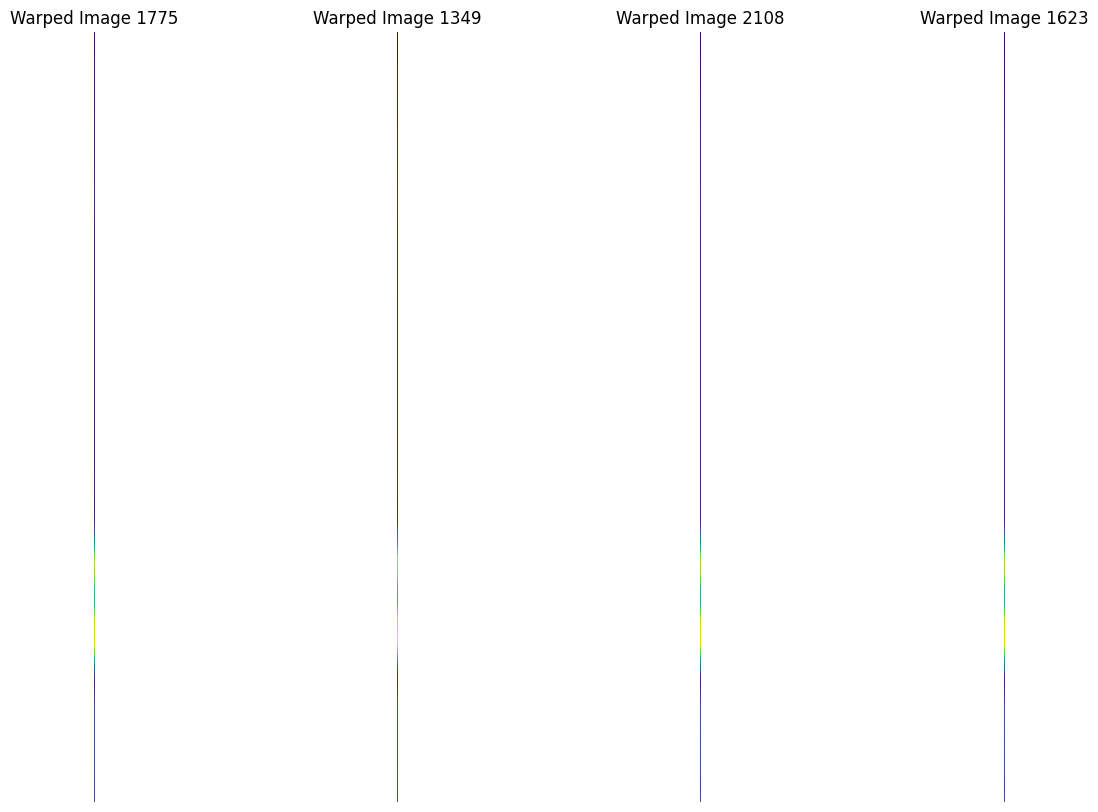

In [13]:
# Create a list to hold the warped images
warped_images = []
reg_factor = 0.1  # adjust this as needed


# For each other image, find the homography to the base image and warp the image
for i, img in enumerate(images_gray):
    if i == base_image_index:
        continue

    matches = flann.match(descriptors_sift[base_image_index], descriptors_sift[i])
    
    # We need at least 4 matches to compute a homography
    if len(matches) > 4:
        src_pts = np.float32([ keypoints_sift[i][m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ keypoints_sift[base_image_index][m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
        
        # Compute Homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        
        # Remove outliers
        matches_mask = mask.ravel().tolist()
        matches = [m for m, mask in zip(matches, matches_mask) if mask]

        # Re-compute Homography after outlier removal
        if len(matches) > 4:
            src_pts = np.float32([ keypoints_sift[i][m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
            dst_pts = np.float32([ keypoints_sift[base_image_index][m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

            distortion = compute_distortion(M)
            # Compute a penalty term for the distortion
            penalty = reg_factor * distortion
            
            scores[i] -= penalty

            # Warp image - using the original non-grayscale image here
            height, width, _ = subset_images[i].shape
            warped_image = cv2.warpPerspective(subset_images[i], M, (width, height))

            warped_images.append(warped_image)
        else:
            print(f"Not enough matches between image {base_image_index} and image {i} after outlier removal.")
    else:
        print(f"Not enough matches between image {base_image_index} and image {i} to compute a homography.")

# Show the warped images
plt.figure(figsize=(15,10))

for i, index in enumerate(selected_indices):
    plt.subplot(1, 4, i+1)  # 1 row, 4 cols, position i+1
    plt.imshow(warped_image[index])
    plt.title(f'Warped Image {subset_labels[index]}')
    plt.axis('off')
    
plt.show()


#### Reorder and create GIF